### Importing libraries

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 

In [3]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95 #Using 95% of the available memory of the GPU
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

def set_seed(sd=144):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

This part imports the dataset. I used the flickr dataset but I am considering other datsets as well. Particularly more related to urban space. 

In [4]:
# importing images and text related to each image 
dir_Flickr_jpg = "Flickr_Data/images"
dir_Flickr_text = "Flickr_Data/Flickr_TextData/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print(len(jpgs))

8091


In [5]:
#Finding the captions for each image.
file = open(dir_Flickr_text,'r', encoding='utf8')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splitting the caption dataset at the required position
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])

                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  


a cart containig two men being pulled by horses in the rain .
a brown dog in a pink shirt runs through a field .
a blonde child swims .
two girls are walking arm in arm past an amusement arcade .
a group of six children sit at a wooden table .


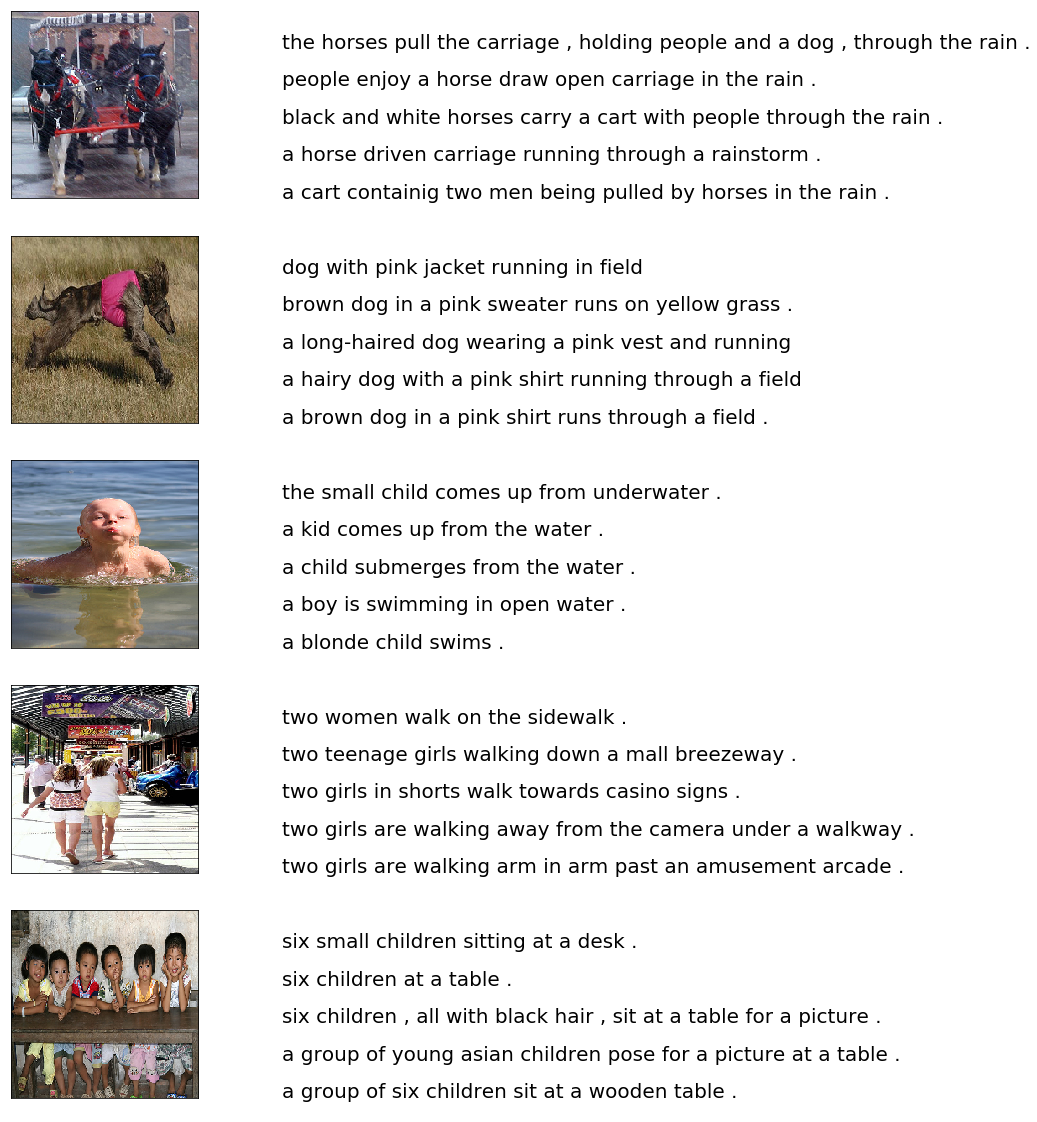

In [7]:
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from PIL import Image

npic = 5 # Displaying 5 images from the dataset
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[-15:-10]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    print(captions[0])
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [27]:
# preprocessing the data removing numbers and punctuations.
import string
text_original = "Just convert this text 10 times, so I will know!!! "

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

Just convert this text 10 times, so I will know!!! 

Remove punctuations..
Just convert this text 10 times so I will know 

Remove a single character word..
 Just convert this text 10 times so will know

Remove words with numeric values..
    Just       : True
    convert    : True
    this       : True
    text       : True
    10         : False
    times      : True
    so         : True
    will       : True
    know       : True
 Just convert this text times so will know


In [12]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

In [13]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [14]:
df_txt0[:5]

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden pla...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into...


In [16]:
from keras.applications import VGG16

modelvgg = VGG16(include_top=True,weights=None)
## load the locally saved weights 
modelvgg.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
## show the deep learning model
modelvgg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Extracting features from images using VGG16 model. 

In [18]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224 #image size is fixed at 224 because VGG16 model has been pre-trained to take that size.
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs):
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

### The caption and related images are merged here

In [29]:
dimages, keepindex = [],[]
# Creating a datframe where only first caption is taken for processing
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)

#fnames are the names of the image files        
fnames = df_txt0["filename"].iloc[keepindex].values
#dcaptions are the captions of the images 
dcaptions = df_txt0["caption"].iloc[keepindex].values
#dimages are the actual features of the images
dimages = np.array(dimages)

### Since LSTM model takes vectors as input, captions should be converted to vectors. 

In [31]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]
